# Polygenic Risk Scores

The csv files were extracted from this file: `data/ROSMAP_SEAAD_AD_107.rds`, using the following 3 lines of R code:

```R
df <- readRDS("data/ROSMAP_SEAAD_AD_107.rds")
write.csv(df[1], "data/SNPs_metadata.csv", row.names = TRUE)
write.csv(df[2], "data/SNPs.csv", row.names = TRUE)
```

The polygenic risk score $PRS_i$ for sample $i$ is then calculated using:
$$
PRS_i = \sum_{j=1}^M \beta_j \cdot G_{ij}
$$

where $\beta_j$ are the weights from the study (odds-ratio), and $G_{ij}$ the dosage of risk SNP $j$ in sample $i$


Same as the other TWO notebooks, but now I use the actual weights from the paper that I found. This is from the same Wightman paper: (Wightman 2021): https://www.nature.com/articles/s41588-021-00921-z

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [64]:
snps = pd.read_csv("data/SNPs.csv", index_col=0)
snps_meta = pd.read_csv("data/SNPs_metadata.csv", index_col=0).replace({"TRUE": "T"})  # Fix a small mistake in the metadata

weights_file = "data/AD_variant_wightman.xlsx"
weights = pd.read_excel(weights_file, index_col=0)
weights["Gene"] = weights.index
weights.set_index("Lead variant", inplace=True)

In [66]:
"rs429358" in weights.index, "rs7412" in weights.index  # Check if APOE e2/e4 SNPs are in the weights

(False, False)

In [67]:
# check overlap in pos
overlap_variants = snps_meta[snps_meta.index.isin(weights.index)].index
print(len(overlap_variants), "variants overlap with weights, out of", len(snps_meta), "total variants in metadata and", len(weights), "total variants in weights.")

overlap = snps_meta[snps_meta.index.isin(overlap_variants)].copy()

weights_overlap = weights[weights.index.isin(overlap_variants)]
weights_overlap

35 variants overlap with weights, out of 106 total variants in metadata and 38 total variants in weights.


,Position (GRCh37),A1,A1 Freq,BETA,SE,P,N,Gene
Lead variant,,,,,,,,
rs679515,1:207750568,C,0.8200,-0.0220,0.0021,2.42x10-25,762176,CR1
rs115186657,2:106235428,C,0.0035,0.0800,0.0140,1.33x10-8,727537,FHL2
rs4663105,2:127891427,C,0.4100,0.0220,0.0014,3.92x10-58,1078540,BIN1
rs7597763,2:234082577,C,0.4500,0.0092,0.0016,4.65x10-9,819541,INPPD5
rs4504245,4:11014822,G,0.7900,-0.0120,0.0017,5.23x10-12,1080458,CLNK
rs871269,5:150432388,T,0.3200,-0.0088,0.0014,1.37x10-9,1089904,TNIP1
rs6891966,5:156526331,G,0.7700,0.0099,0.0016,7.91x10-10,1089230,HAVCR2
rs1846190,6:32583813,A,0.3000,-0.0130,0.0018,2.66x10-14,754040,HLA-DRB1
rs187370608,6:40942196,G,0.9970,-0.1600,0.0150,1.26x10-25,791668,TREM2


In [68]:
# and get the weights for these SNPs
overlap["weights"] = weights_overlap.loc[overlap_variants, "BETA"].values
overlap["GWAS A1"] = weights_overlap.loc[overlap_variants, "A1"].values
overlap["Gene"] = weights_overlap.loc[overlap_variants, "Gene"].values

In [69]:
snps_overlap = snps.loc[overlap.index].copy()

In [70]:
# if A1 doesn't match COUNTED in overlap, we need to flip the corresponding dosages in snps_overlap (2 - dosage)
for i, row in overlap.iterrows():
    if row["GWAS A1"] != row["COUNTED"]:
        snps_overlap.loc[i] = 2 - snps_overlap.loc[i]

In [71]:
overlap.sort_values(by="weights", ascending=False)

,CHR,SNP,X.C.M,POS,COUNTED,ALT,weights,GWAS A1,Gene
rs115186657,2,chr2:105618971:A:C,0,105618971,A,C,0.0800,C,FHL2
rs11218343,11,chr11:121564878:T:C,0,121564878,T,C,0.0270,T,SORL1
rs4663105,2,chr2:127133851:A:C,0,127133851,A,C,0.0220,C,BIN1
rs1582763,11,chr11:60254475:G:A,0,60254475,G,A,0.0160,G,MS4A6A
rs117618017,15,chr15:63277703:C:T,0,63277703,C,T,0.0150,T,APH1B
rs9369716,6,chr6:47584444:A:T,0,47584444,A,T,0.0130,T,CD2AP
rs7384878,7,chr7:100334426:C:T,0,100334426,C,T,0.0120,T,ZCWPW1
rs12590654,14,chr14:92472511:G:A,0,92472511,G,A,0.0120,G,SLC24A4
rs602602,15,chr15:58764824:T:A,0,58764824,T,A,0.0110,T,ADAM10
rs7912495,10,chr10:11676714:A:G,0,11676714,A,G,0.0100,G,ECHDC3


Text(0, 0.5, 'Frequency')

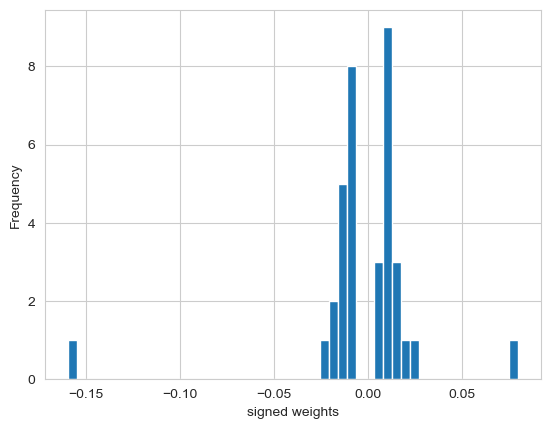

In [72]:
plt.hist((overlap["weights"]), bins=50)
plt.xlabel("signed weights")
plt.ylabel("Frequency")

In [73]:
prss = (np.array(snps_overlap) * overlap["weights"].values.reshape(-1, 1)).sum(axis=0)
prss = pd.Series(prss, index=snps_overlap.columns, name="PRS")

prss.to_csv("data/PRS_Wightman.csv")

prss

H20.33.045   -0.306817
H20.33.044   -0.293639
H21.33.045   -0.377335
H20.33.046   -0.287165
H20.33.014   -0.331064
                ...   
R6808939     -0.404587
R7423003     -0.254851
R4703595     -0.292433
R2213536     -0.336763
R3438797     -0.313826
Name: PRS, Length: 2107, dtype: float64

In [74]:
prss_79 = pd.read_csv("data/PRS.csv", index_col=0)
prss_79

,PRS
H20.33.045,-0.139991
H20.33.044,-0.293398
H21.33.045,-0.616018
H20.33.046,-0.012919
H20.33.014,-0.156987
...,...
R6808939,-0.857923
R7423003,0.053622
R4703595,0.016418
R2213536,-0.397821


In [75]:
prss_finngen = pd.read_csv("data/PRS_FinnGen.csv", index_col=0)
prss_finngen

,PRS
H20.33.045,1.096164
H20.33.044,0.077114
H21.33.045,1.308485
H20.33.046,0.336903
H20.33.014,-0.059045
...,...
R6808939,0.616547
R7423003,0.214772
R4703595,0.103615
R2213536,-0.033968


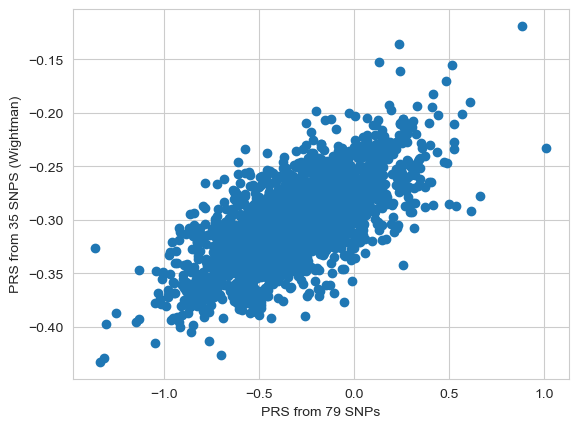

                 PRS
H20.33.045 -0.139991
H20.33.044 -0.293398
H21.33.045 -0.616018
H20.33.046 -0.012919
H20.33.014 -0.156987
...              ...
R6808939   -0.857923
R7423003    0.053622
R4703595    0.016418
R2213536   -0.397821
R3438797    0.044925

[2107 rows x 1 columns] H20.33.045   -0.306817
H20.33.044   -0.293639
H21.33.045   -0.377335
H20.33.046   -0.287165
H20.33.014   -0.331064
                ...   
R6808939     -0.404587
R7423003     -0.254851
R4703595     -0.292433
R2213536     -0.336763
R3438797     -0.313826
Name: PRS, Length: 2107, dtype: float64


C:\Users\timo\AppData\Local\Temp\ipykernel_26716\3106332224.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(prss_79, prss)


In [76]:
plt.scatter(prss_79, prss)
plt.xlabel("PRS from 79 SNPs")
plt.ylabel("PRS from 35 SNPS (Wightman)")
plt.show()

# check correlation
from scipy.stats import pearsonr
corr, p_value = pearsonr(prss_79, prss)
print(prss_79, prss)

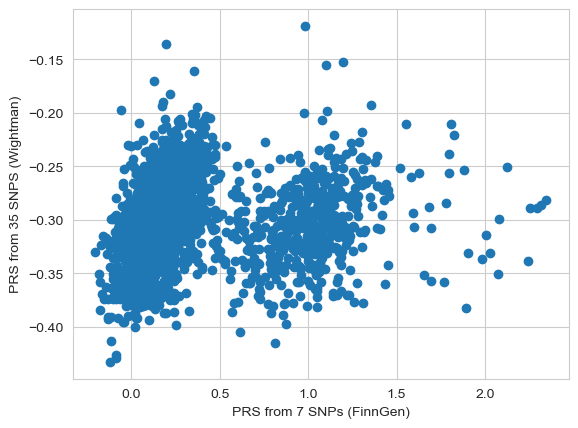

C:\Users\timo\AppData\Local\Temp\ipykernel_26716\3804996346.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(prss_finngen, prss)


                 PRS
H20.33.045  1.096164
H20.33.044  0.077114
H21.33.045  1.308485
H20.33.046  0.336903
H20.33.014 -0.059045
...              ...
R6808939    0.616547
R7423003    0.214772
R4703595    0.103615
R2213536   -0.033968
R3438797    0.248671

[2107 rows x 1 columns] H20.33.045   -0.306817
H20.33.044   -0.293639
H21.33.045   -0.377335
H20.33.046   -0.287165
H20.33.014   -0.331064
                ...   
R6808939     -0.404587
R7423003     -0.254851
R4703595     -0.292433
R2213536     -0.336763
R3438797     -0.313826
Name: PRS, Length: 2107, dtype: float64


In [77]:
plt.scatter(prss_finngen, prss)
plt.xlabel("PRS from 7 SNPs (FinnGen)")
plt.ylabel("PRS from 35 SNPS (Wightman)")
plt.show()

# check correlation
from scipy.stats import pearsonr
corr, p_value = pearsonr(prss_finngen, prss)
print(prss_finngen, prss)

(array([  6.,  83., 277., 558., 634., 395., 120.,  28.,   4.,   2.]),
 array([-0.4326759 , -0.40127368, -0.36987146, -0.33846924, -0.30706702,
        -0.2756648 , -0.24426258, -0.21286036, -0.18145814, -0.15005592,
        -0.1186537 ]),
 <BarContainer object of 10 artists>)

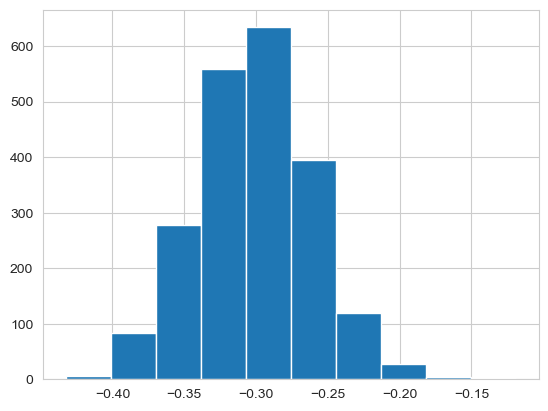

In [78]:
plt.hist(prss)

In [94]:
# validate the PRSs against the clinical metadata

clinical = pd.read_csv("data/ROSMAP_clinical.csv", index_col="individualID")

# check overlap between clinical and PRS
overlap = clinical.index.intersection(prss.index)
print(f"Found {len(overlap)} overlapping samples between clinical and PRS data.")

clinical_overlap = clinical.loc[overlap]
prss_overlap = prss.loc[overlap]
prss_79_overlap = prss_79.loc[overlap]
prss_finngen_overlap = prss_finngen.loc[overlap]

df = clinical_overlap.copy()
df["PRS_79"] = prss_79_overlap.values.flatten()
df["PRS_Wightman"] = prss_overlap.values.flatten()
df["PRS_FinnGen"] = prss_finngen_overlap.values.flatten()
df["APOE"] = clinical_overlap["apoe_genotype"].astype(str)


Found 2016 overlapping samples between clinical and PRS data.


In [81]:
sns.set_style("whitegrid")

<Axes: xlabel='PRS_Wightman', ylabel='PRS_FinnGen'>

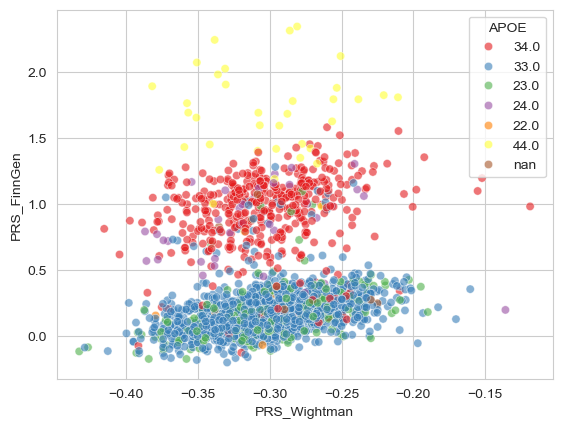

In [96]:
sns.scatterplot(data=df, x="PRS_Wightman", y="PRS_FinnGen", hue="APOE", alpha=0.6, palette="Set1")

In [98]:
df.columns

Index(['projid', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype',
       'age_at_visit_max', 'age_first_ad_dx', 'age_death',
       'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc',
       'cogdx', 'dcfdx_lv', 'PRS_79', 'PRS_Wightman', 'PRS_FinnGen', 'APOE'],
      dtype='object')

<Axes: xlabel='braaksc', ylabel='PRS_Wightman'>

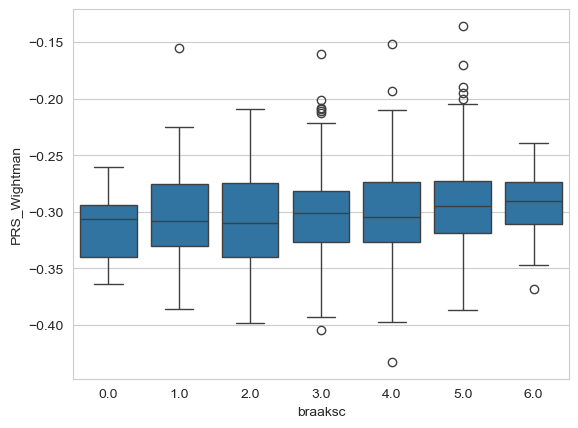

In [102]:
sns.boxplot(df, y="PRS_Wightman", x="braaksc")

<Axes: xlabel='braaksc', ylabel='PRS_79'>

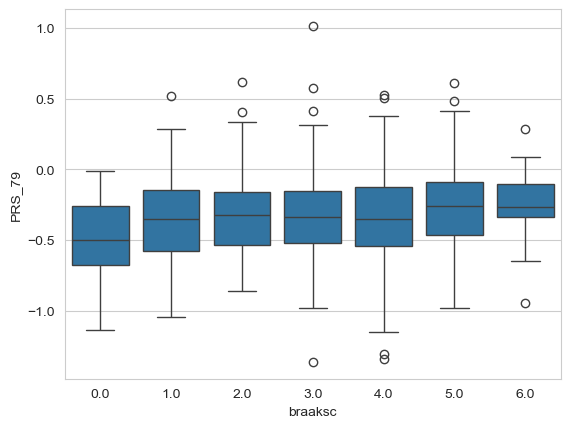

In [104]:
sns.boxplot(df, y="PRS_79", x="braaksc")

<Axes: xlabel='braaksc', ylabel='PRS_FinnGen'>

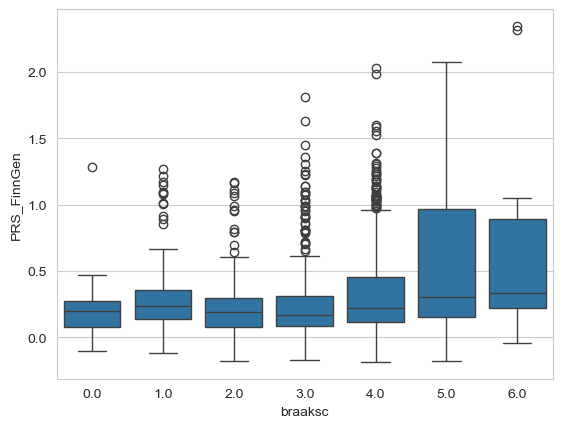

In [105]:
sns.boxplot(df, y="PRS_FinnGen", x="braaksc")

In [106]:
# use the clinical data to map the Donor IDs to projid, such that we also a a mapping from the projid to the PRS

clinical["projid"]


prss_by_projid = pd.Series(prss_overlap.values, index=clinical["projid"][prss_overlap.index], name="PRS")
prss_by_projid.to_csv("data/PRS_Wightman_by_projid.csv")

prss_by_projid

projid
10101589   -0.293943
86767530   -0.349648
9650662    -0.284488
50402855   -0.304921
20544321   -0.314498
              ...   
11699350   -0.263525
46757148   -0.346681
74494179   -0.272221
38113465   -0.278821
90214403   -0.308574
Name: PRS, Length: 2016, dtype: float64